## Feature Selection & ML

In [28]:
import os
import numpy as np
import joblib
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.feature_selection import RFE, SelectKBest, f_classif, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
import dotenv


dotenv.load_dotenv()

# ==== SETTINGS ====
IS_HYPERPARAM_TUNING = True                 # !!!!!
modmaFeaturesDirPath = os.getenv("MODMA_10S_FEATURES_DIR")                              # !!!!!
predctFeaturesDirPath = os.getenv("PREDCT_10S_FEATURES_DIR")                            # !!!!!
modelDirForSavelPath = "/Users/wachiii/Workschii/brain-mdd/model/20250330_10s_hpt/"         # !!!!!

OUTLIER_THRESHOLD = 3.0


featuresTypePathDict = {
    "bandpower": "/bandpower/",
    "coherence": "/coherence/",
    "hfd": "/hfd/",
    "relativepower": "/relativepower/",
    "cd": "/cd/"
}

## Interquatile Range (IQR) Method

Lower (e.g., 1.0 × IQR) → More values considered outliers (stricter).

Higher (e.g., 3.0 × IQR) → Fewer values considered outliers (looser, only extreme ones removed).

In [29]:
def remove_outliers_iqr_3d(data, threshold=3):
    numEpochs, numBands, numChannels = data.shape
    mask = np.ones(numEpochs, dtype=bool)

    for band in range(numBands):
        for ch in range(numChannels):
            values = data[:, band, ch]
            Q1 = np.percentile(values, 25)
            Q3 = np.percentile(values, 75)
            IQR = Q3 - Q1

            lowerBound = Q1 - threshold * IQR
            upperBound = Q3 + threshold * IQR

            mask &= (values >= lowerBound) & (values <= upperBound)

    return data[mask], mask

def remove_outliers_iqr_2d(data, threshold=3):
    numEpochs, numChannels = data.shape
    mask = np.ones(numEpochs, dtype=bool)

    for ch in range(numChannels):
        values = data[:, ch]
        Q1 = np.percentile(values, 25)
        Q3 = np.percentile(values, 75)
        IQR = Q3 - Q1

        lowerBound = Q1 - threshold * IQR
        upperBound = Q3 + threshold * IQR

        mask &= (values >= lowerBound) & (values <= upperBound)

    return data[mask], mask

## Single Feature Type

### 1. Get feature ☁️

In [30]:
# === CHANGE THIS TO SWITCH BETWEEN FEATURE TYPE ===
whichFeatureType = "relativepower"  # "bandpower", "coherence", "hfd", "relativepower" # !!!!
whichDirForModelPath = modelDirForSavelPath + "relativepower"
# ==================================================

hcModmaFeaturesPath = modmaFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_HC.npy"
hcPredctFeaturesPath = predctFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_HC.npy"
mddModmaFeaturesPath = modmaFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_MDD.npy"
mddPredctFeaturesPath = predctFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_MDD.npy"
hcModmaUnseenFeaturesPath = modmaFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_HC_unseen.npy"
hcPredctUnseenFeaturesPath = predctFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_HC_unseen.npy"
mddModmaUnseenFeaturesPath = modmaFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_MDD_unseen.npy"
mddPredctUnseenFeaturesPath = predctFeaturesDirPath + featuresTypePathDict[whichFeatureType] + f"{whichFeatureType}_MDD_unseen.npy"

hcModmaFeatures = np.load(hcModmaFeaturesPath)
hcPredctFeatures = np.load(hcPredctFeaturesPath)
mddModmaFeatures = np.load(mddModmaFeaturesPath)
mddPredctFeatures = np.load(mddPredctFeaturesPath)
hcModmaFeaturesUnseen = np.load(hcModmaUnseenFeaturesPath)
hcPredctFeaturesUnseen = np.load(hcPredctUnseenFeaturesPath)
mddModmaFeaturesUnseen = np.load(mddModmaUnseenFeaturesPath)
mddPredctFeaturesUnseen = np.load(mddPredctUnseenFeaturesPath)

hcFeature = np.concatenate((hcModmaFeatures, hcPredctFeatures), axis=0)
mddFeature = np.concatenate((mddModmaFeatures, mddPredctFeatures), axis=0)
hcFeatureUnseen = np.concatenate((hcModmaFeaturesUnseen, hcPredctFeaturesUnseen), axis=0)
mddFeatureUnseen = np.concatenate((mddModmaFeaturesUnseen, mddPredctFeaturesUnseen), axis=0)

print(f"hcModmaFeatures shape: {hcModmaFeatures.shape}")
print(f"hcPredctFeatures shape: {hcPredctFeatures.shape}")
print(f"mddModmaFeatures shape: {mddModmaFeatures.shape}")
print(f"mddPredctFeatures shape: {mddPredctFeatures.shape}")
print("---------------------")
print(f"hcFeature shape: {hcFeature.shape}")
print(f"mddFeature shape: {mddFeature.shape}")
print("---------------------")
print(f"hcModmaUnseenFeatures shape: {hcModmaFeaturesUnseen.shape}")
print(f"hcPredctUnseenFeatures shape: {hcPredctFeaturesUnseen.shape}")
print(f"mddModmaUnseenFeatures shape: {mddModmaFeaturesUnseen.shape}")
print(f"mddPredctUnseenFeatures shape: {mddPredctFeaturesUnseen.shape}")
print("---------------------")
print(f"hcFeatureUnseen shape: {hcFeatureUnseen.shape}")
print(f"mddFeatureUnseen shape: {mddFeatureUnseen.shape}")

hcModmaFeatures shape: (362, 5, 16)
hcPredctFeatures shape: (641, 5, 16)
mddModmaFeatures shape: (286, 5, 16)
mddPredctFeatures shape: (439, 5, 16)
---------------------
hcFeature shape: (1003, 5, 16)
mddFeature shape: (725, 5, 16)
---------------------
hcModmaUnseenFeatures shape: (75, 5, 16)
hcPredctUnseenFeatures shape: (90, 5, 16)
mddModmaUnseenFeatures shape: (75, 5, 16)
mddPredctUnseenFeatures shape: (90, 5, 16)
---------------------
hcFeatureUnseen shape: (165, 5, 16)
mddFeatureUnseen shape: (165, 5, 16)


### 2. Outlier Removal 🍂

In [31]:
hcFeature, hcMask = remove_outliers_iqr_3d(hcFeature, OUTLIER_THRESHOLD)
mddFeature, mddMask = remove_outliers_iqr_3d(mddFeature, OUTLIER_THRESHOLD)
print(f"hcFeature shape after outlier removal: {hcFeature.shape}")
print(f"mddFeature shape after outlier removal: {mddFeature.shape}")

min_size = min(hcFeature.shape[0], mddFeature.shape[0])
if hcFeature.shape[0] > min_size:
    indices = np.random.choice(hcFeature.shape[0], min_size, replace=False)
    hcFeature = hcFeature[indices]
else:
    indices = np.random.choice(mddFeature.shape[0], min_size, replace=False)
    mddFeature = mddFeature[indices] 
print(f"hcFeature shape after balancing: {hcFeature.shape}")
print(f"mddFeature shape after balancing: {mddFeature.shape}")

hcFeature shape after outlier removal: (594, 5, 16)
mddFeature shape after outlier removal: (485, 5, 16)
hcFeature shape after balancing: (485, 5, 16)
mddFeature shape after balancing: (485, 5, 16)


### 3. Prepare Feature 🍳

In [32]:
hcFeature = hcFeature.reshape(hcFeature.shape[0], -1)
mddFeature = mddFeature.reshape(mddFeature.shape[0], -1)
hcFeatureUnseen = hcFeatureUnseen.reshape(hcFeatureUnseen.shape[0], -1)
mddFeatureUnseen = mddFeatureUnseen.reshape(mddFeatureUnseen.shape[0], -1)

In [33]:
X_train = np.concatenate((hcFeature, mddFeature), axis=0)
y_train = np.concatenate((np.zeros(hcFeature.shape[0]), np.ones(mddFeature.shape[0])), axis=0)

X_test = np.concatenate((hcFeatureUnseen, mddFeatureUnseen), axis=0)
y_test = np.concatenate((np.zeros(hcFeatureUnseen.shape[0]), np.ones(mddFeatureUnseen.shape[0])), axis=0)

### 4. Train Models 🍛

In [34]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "SVM": (SVC(probability=True, random_state=42), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 15]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [10, 20]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.2]}),
    "AdaBoost": (AdaBoostClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]}),
}

featureSelectors = {
    "NoFeatureSelection": None
}

def get_stratified_kfold_data(X, y, nSplits=5):
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=42)
    return skf.split(X, y)

Training KNN with NoFeatureSelection...
Best hyperparameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Best fold: 3 with ACC score: 0.8866
Training SVM with NoFeatureSelection...
Best hyperparameters for SVM: {'C': 10, 'kernel': 'linear'}
Best fold: 6 with ACC score: 0.8557
Training Decision Tree with NoFeatureSelection...
Best hyperparameters for Decision Tree: {'max_depth': 10}
Best fold: 9 with ACC score: 0.8247
Training Random Forest with NoFeatureSelection...
Best hyperparameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Best fold: 3 with ACC score: 0.9278
Training Logistic Regression with NoFeatureSelection...
Best hyperparameters for Logistic Regression: {'C': 1}
Best fold: 5 with ACC score: 0.7629
Training Gradient Boosting with NoFeatureSelection...
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 100}
Best fold: 3 with ACC score: 0.9072
Training AdaBoost with NoFeatureSelection...


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best hyperparameters for AdaBoost: {'learning_rate': 1, 'n_estimators': 100}


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best fold: 3 with ACC score: 0.8866


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



KNN with NoFeatureSelection - Final evaluation
Final Accuracy: 0.5030
Final Precision: 0.5027
Final Recall: 0.5636
Final F1 Score: 0.5314
Best Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Hyperparameter Tuning Details: [{'params': {'n_neighbors': 3, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.7154639175257732), 'std_test_score': np.float64(0.0453373885098887)}, {'params': {'n_neighbors': 3, 'weights': 'distance'}, 'mean_test_score': np.float64(0.7164948453608248), 'std_test_score': np.float64(0.04458092435142196)}, {'params': {'n_neighbors': 5, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.7010309278350515), 'std_test_score': np.float64(0.05542136105449736)}, {'params': {'n_neighbors': 5, 'weights': 'distance'}, 'mean_test_score': np.float64(0.7010309278350515), 'std_test_score': np.float64(0.05542136105449736)}, {'params': {'n_neighbors': 7, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.6865979381443299), 'std_test_score': np.float64(0.05230

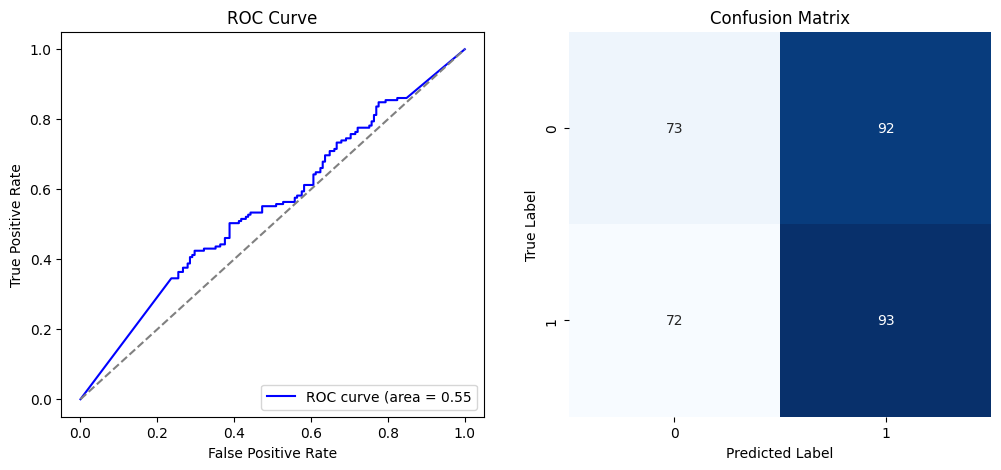

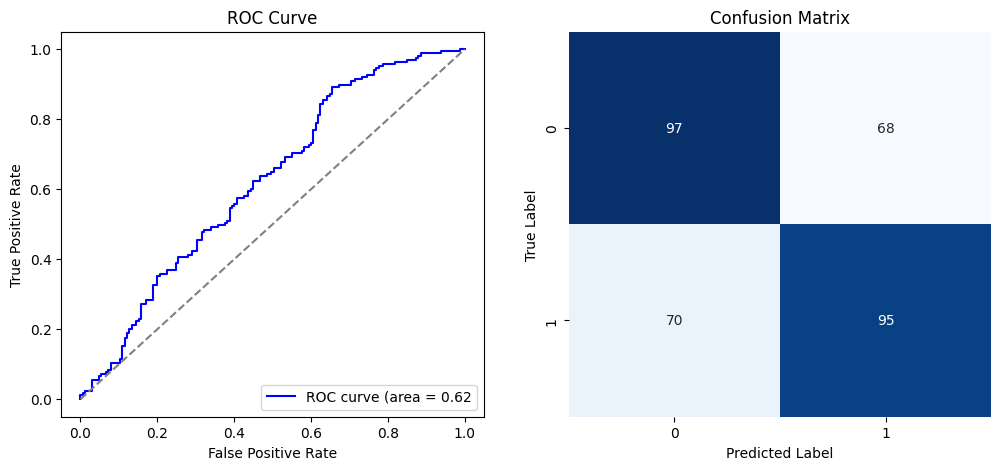

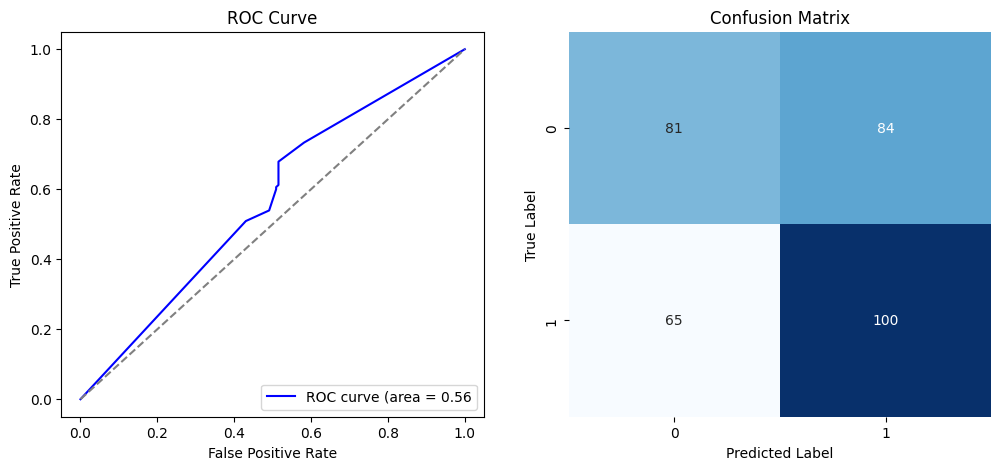

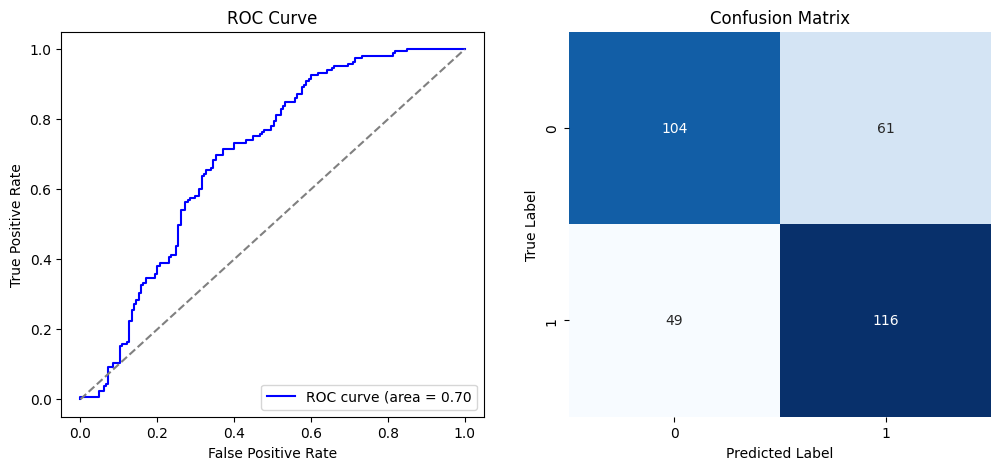

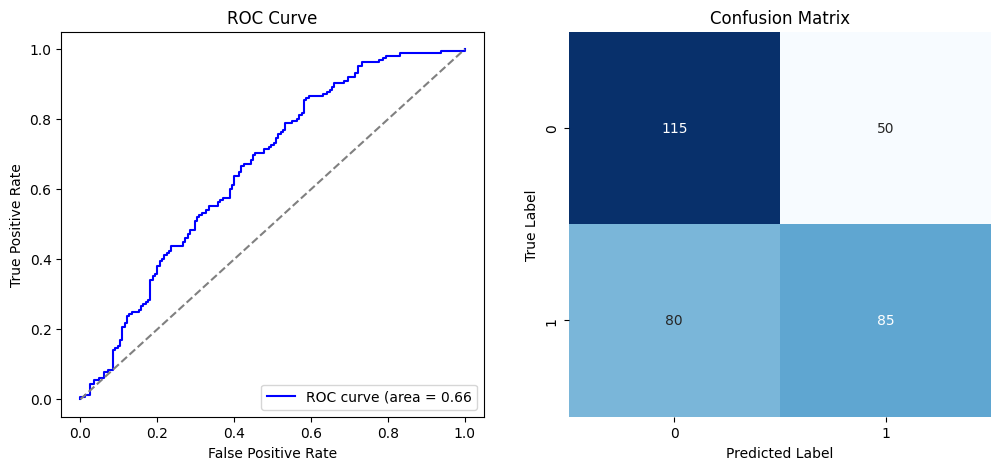

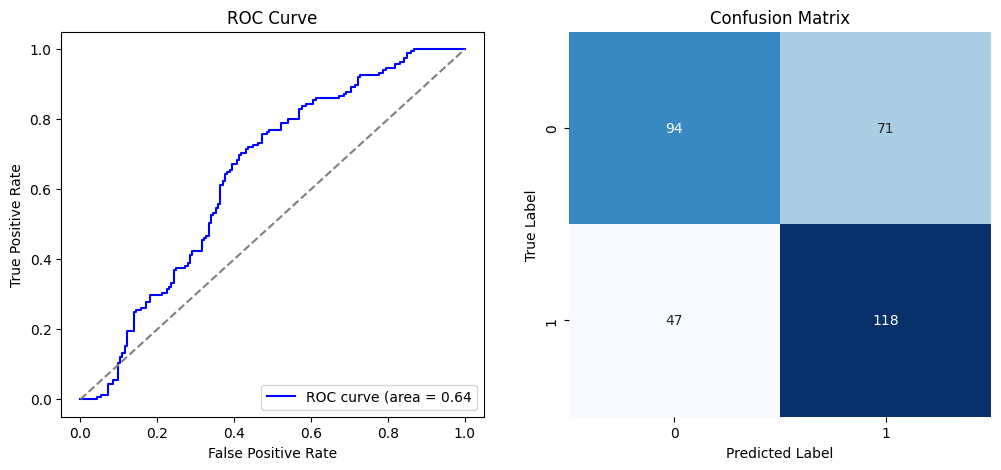

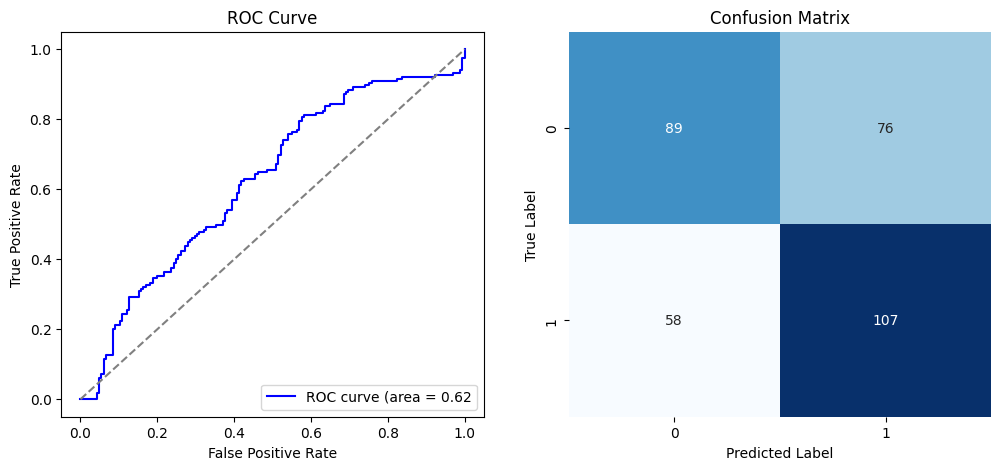

In [35]:
results = []

for modelName, (model, paramGrid) in models.items():
    for featureSelectorName, featureSelector in featureSelectors.items():
        print(f"Training {modelName} with {featureSelectorName}...")
        if featureSelector is not None:
            selector = featureSelector
        else:
            selector = None
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        bestFold = None
        bestAcc = -np.inf
        bestFoldModel = None
        bestFoldIdx = None
        hyperparamTuningDetails = []  

        if IS_HYPERPARAM_TUNING and paramGrid:
            gridSearch = GridSearchCV(model, paramGrid, cv=5, scoring="accuracy", n_jobs=-1, return_train_score=True)
            gridSearch.fit(X_train, y_train)
            model = gridSearch.best_estimator_
            bestParams = gridSearch.best_params_
            print(f"Best hyperparameters for {modelName}: {bestParams}")

            for i, params in enumerate(gridSearch.cv_results_["params"]):
                meanTestScore = gridSearch.cv_results_["mean_test_score"][i]
                stdTestScore = gridSearch.cv_results_["std_test_score"][i]
                hyperparamTuningDetails.append({
                    "params": params,
                    "mean_test_score": meanTestScore,
                    "std_test_score": stdTestScore
                })
        else:
            bestParams = None

        foldAccuracies = []
        foldPrecisions = []
        foldRecalls = []
        foldF1Scores = []
        selectedFeatures = []
        foldHcTrain = []
        foldMddTrain = []
        foldHcVal = []
        foldMddVal = []
        foldHcTest = []
        foldMddTest = []

        for fold, (trainIdx, valIdx) in enumerate(skf.split(X_train, y_train)):
            XTrain, XVal = X_train[trainIdx], X_train[valIdx]
            yTrain, yVal = y_train[trainIdx], y_train[valIdx]

            hcTrain = int(np.sum(yTrain == 0))
            mddTrain = int(np.sum(yTrain == 1))
            hcVal = int(np.sum(yVal == 0))
            mddVal = int(np.sum(yVal == 1))
            hcTest = int(np.sum(y_test == 0))
            mddTest = int(np.sum(y_test == 1))

            foldHcTrain.append(hcTrain)
            foldMddTrain.append(mddTrain)
            foldHcVal.append(hcVal)
            foldMddVal.append(mddVal)
            foldHcTest.append(hcTest)
            foldMddTest.append(mddTest)

            if selector is not None:
                XTrain = selector.fit_transform(XTrain, yTrain)
                XVal = XVal[:, selector.get_support()]

            model.fit(XTrain, yTrain)

            yPred = model.predict(XVal)
            acc = accuracy_score(yVal, yPred)
            prec = precision_score(yVal, yPred)
            rec = recall_score(yVal, yPred)
            f1 = f1_score(yVal, yPred)

            foldAccuracies.append(float(acc))
            foldPrecisions.append(float(prec))
            foldRecalls.append(float(rec))
            foldF1Scores.append(float(f1))

            if selector is not None:
                selectedFeatures.append(np.where(selector.get_support())[0].tolist())

            modelDir = os.path.join(whichDirForModelPath, f"{modelName}_{featureSelectorName}")
            if not os.path.exists(modelDir):
                os.makedirs(modelDir)
            modelFilename = os.path.join(modelDir, f"model_fold_{fold + 1}.pkl")
            joblib.dump(model, modelFilename)

            if acc > bestAcc:
                bestAcc = acc
                bestFold = model
                bestFoldIdx = fold

        print(f"Best fold: {bestFoldIdx + 1} with ACC score: {bestAcc:.4f}")

        if selector is not None:
            X_train_selected = selector.fit_transform(X_train, y_train)
            X_test_selected = X_test[:, selector.get_support()]
        else:
            X_train_selected = X_train
            X_test_selected = X_test

        bestFold.fit(X_train_selected, y_train)
        yTestPred = bestFold.predict(X_test_selected)
        finalAccuracy = accuracy_score(y_test, yTestPred)
        finalPrecision = precision_score(y_test, yTestPred)
        finalRecall = recall_score(y_test, yTestPred)
        finalF1 = f1_score(y_test, yTestPred)

        yProb = bestFold.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, yProb)
        roc_auc = auc(fpr, tpr)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f}')
        ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve')
        ax[0].legend(loc='lower right')

        cm = confusion_matrix(y_test, yTestPred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        ax[1].set_xlabel('Predicted Label')
        ax[1].set_ylabel('True Label')
        ax[1].set_title('Confusion Matrix')

        plotFilename = os.path.join(whichDirForModelPath, f"{modelName}_{featureSelectorName}_best_fold_roc_cm.png")
        plt.savefig(plotFilename)

        results.append({
            "model": modelName,
            "feature_selection": featureSelectorName,
            "avg_accuracy": f"{np.mean(foldAccuracies):.4f} ± {np.std(foldAccuracies):.4f}",
            "avg_precision": f"{np.mean(foldPrecisions):.4f} ± {np.std(foldPrecisions):.4f}",
            "avg_recall": f"{np.mean(foldRecalls):.4f} ± {np.std(foldRecalls):.4f}",
            "avg_f1_score": f"{np.mean(foldF1Scores):.4f} ± {np.std(foldF1Scores):.4f}",
            "final_accuracy": f"{finalAccuracy:.4f}",
            "final_precision": f"{finalPrecision:.4f}",
            "final_recall": f"{finalRecall:.4f}",
            "final_f1_score": f"{finalF1:.4f}",
            "significant_features": np.unique([item for sublist in selectedFeatures for item in sublist]).tolist(),
            "folds_accuracy": foldAccuracies,
            "folds_precision": foldPrecisions,
            "folds_recall": foldRecalls,
            "folds_f1_score": foldF1Scores,
            "fold_hc_train": [int(x) for x in foldHcTrain], 
            "fold_mdd_train": [int(x) for x in foldMddTrain],  
            "fold_hc_val": [int(x) for x in foldHcVal], 
            "fold_mdd_val": [int(x) for x in foldMddVal],  
            "fold_hc_test": [int(x) for x in foldHcTest],  
            "fold_mdd_test": [int(x) for x in foldMddTest],
            "best_fold": bestFoldIdx + 1,
            "best_hyperparameters": bestParams,
            "hyperparam_tuning_details": hyperparamTuningDetails
        })

resultsDf = pd.DataFrame(results)
resultsDf.to_csv(os.path.join(whichDirForModelPath, "results.csv"), index=False)
resultsDf.to_excel(os.path.join(whichDirForModelPath, "results.xlsx"), index=False)

for result in results:
    print(f"\n{result['model']} with {result['feature_selection']} - Final evaluation")
    print(f"Final Accuracy: {result['final_accuracy']}")
    print(f"Final Precision: {result['final_precision']}")
    print(f"Final Recall: {result['final_recall']}")
    print(f"Final F1 Score: {result['final_f1_score']}")
    if result["best_hyperparameters"]:
        print(f"Best Hyperparameters: {result['best_hyperparameters']}")
    if result["hyperparam_tuning_details"]:
        print(f"Hyperparameter Tuning Details: {result['hyperparam_tuning_details']}")

## All Features (Fused)

### 1. Get data ☁️

In [20]:
# === CHANGE THIS TO SWITCH BETWEEN FEATURE TYPE ===
whichDirForModelPath = modelDirForSavelPath + "allFeatures"       # !!!!!

featureTypes = ['bandpower', 'coherence', 'hfd', 'relativepower']
featuresPathDict = {}

for featureType in featureTypes:
    featuresPathDict[f"hc{featureType.capitalize()}ModmaFeaturesPath"] = (
        modmaFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_HC.npy")
    featuresPathDict[f"hc{featureType.capitalize()}PredctFeaturesPath"] = (
        predctFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_HC.npy")
    featuresPathDict[f"mdd{featureType.capitalize()}ModmaFeaturesPath"] = (
        modmaFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_MDD.npy")
    featuresPathDict[f"mdd{featureType.capitalize()}PredctFeaturesPath"] = (
        predctFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_MDD.npy")
    featuresPathDict[f"hc{featureType.capitalize()}ModmaUnseenFeaturesPath"] = (
        modmaFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_HC_unseen.npy")
    featuresPathDict[f"hc{featureType.capitalize()}PredctUnseenFeaturesPath"] = (
        predctFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_HC_unseen.npy")
    featuresPathDict[f"mdd{featureType.capitalize()}ModmaUnseenFeaturesPath"] = (
        modmaFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_MDD_unseen.npy")
    featuresPathDict[f"mdd{featureType.capitalize()}PredctUnseenFeaturesPath"] = (
        predctFeaturesDirPath + featuresTypePathDict[featureType] + f"{featureType}_MDD_unseen.npy")

loadedFeatures = {}


for key, path in featuresPathDict.items():
    try:
        loadedFeatures[key.replace("Path", "")] = np.load(path)
    except FileNotFoundError:
        print(f"File not found: {path}")
        
for key, value in loadedFeatures.items():
    print(f"{key}: {value.shape}")

hcBandpowerModmaFeatures: (362, 5, 16)
hcBandpowerPredctFeatures: (641, 5, 16)
mddBandpowerModmaFeatures: (286, 5, 16)
mddBandpowerPredctFeatures: (439, 5, 16)
hcBandpowerModmaUnseenFeatures: (75, 5, 16)
hcBandpowerPredctUnseenFeatures: (90, 5, 16)
mddBandpowerModmaUnseenFeatures: (75, 5, 16)
mddBandpowerPredctUnseenFeatures: (90, 5, 16)
hcCoherenceModmaFeatures: (362, 5, 120)
hcCoherencePredctFeatures: (641, 5, 120)
mddCoherenceModmaFeatures: (286, 5, 120)
mddCoherencePredctFeatures: (439, 5, 120)
hcCoherenceModmaUnseenFeatures: (75, 5, 120)
hcCoherencePredctUnseenFeatures: (90, 5, 120)
mddCoherenceModmaUnseenFeatures: (75, 5, 120)
mddCoherencePredctUnseenFeatures: (90, 5, 120)
hcHfdModmaFeatures: (362, 16)
hcHfdPredctFeatures: (641, 16)
mddHfdModmaFeatures: (286, 16)
mddHfdPredctFeatures: (439, 16)
hcHfdModmaUnseenFeatures: (75, 16)
hcHfdPredctUnseenFeatures: (90, 16)
mddHfdModmaUnseenFeatures: (75, 16)
mddHfdPredctUnseenFeatures: (90, 16)
hcRelativepowerModmaFeatures: (362, 5, 16)
h

In [21]:
concatenatedFeatures = {}
concatenatedUnseenFeatures = {}

for featureType in featureTypes:
    try:
        hcModmaKey = f"hc{featureType.capitalize()}ModmaFeatures"
        hcPredctKey = f"hc{featureType.capitalize()}PredctFeatures"
        concatenatedFeatures[f"hc{featureType.capitalize()}Features"] = np.concatenate(
            [loadedFeatures[hcModmaKey], loadedFeatures[hcPredctKey]], axis=0)
        mddModmaKey = f"mdd{featureType.capitalize()}ModmaFeatures"
        mddPredctKey = f"mdd{featureType.capitalize()}PredctFeatures"
        concatenatedFeatures[f"mdd{featureType.capitalize()}Features"] = np.concatenate(
            [loadedFeatures[mddModmaKey], loadedFeatures[mddPredctKey]], axis=0)
        hcModmaUnseenKey = f"hc{featureType.capitalize()}ModmaUnseenFeatures"
        hcPredctUnseenKey = f"hc{featureType.capitalize()}PredctUnseenFeatures"
        concatenatedUnseenFeatures[f"hc{featureType.capitalize()}UnseenFeatures"] = np.concatenate(
            [loadedFeatures[hcModmaUnseenKey], loadedFeatures[hcPredctUnseenKey]], axis=0)
        mddModmaUnseenKey = f"mdd{featureType.capitalize()}ModmaUnseenFeatures"
        mddPredctUnseenKey = f"mdd{featureType.capitalize()}PredctUnseenFeatures"
        concatenatedUnseenFeatures[f"mdd{featureType.capitalize()}UnseenFeatures"] = np.concatenate(
            [loadedFeatures[mddModmaUnseenKey], loadedFeatures[mddPredctUnseenKey]], axis=0)
    except KeyError as e:
        print(f"Missing data for {featureType}: {e}")

print("Training Features:")
for key, value in concatenatedFeatures.items():
    print(f"{key}: {value.shape}")

print("\nUnseen Features:")
for key, value in concatenatedUnseenFeatures.items():
    print(f"{key}: {value.shape}")

Training Features:
hcBandpowerFeatures: (1003, 5, 16)
mddBandpowerFeatures: (725, 5, 16)
hcCoherenceFeatures: (1003, 5, 120)
mddCoherenceFeatures: (725, 5, 120)
hcHfdFeatures: (1003, 16)
mddHfdFeatures: (725, 16)
hcRelativepowerFeatures: (1003, 5, 16)
mddRelativepowerFeatures: (725, 5, 16)

Unseen Features:
hcBandpowerUnseenFeatures: (165, 5, 16)
mddBandpowerUnseenFeatures: (165, 5, 16)
hcCoherenceUnseenFeatures: (165, 5, 120)
mddCoherenceUnseenFeatures: (165, 5, 120)
hcHfdUnseenFeatures: (165, 16)
mddHfdUnseenFeatures: (165, 16)
hcRelativepowerUnseenFeatures: (165, 5, 16)
mddRelativepowerUnseenFeatures: (165, 5, 16)


### 2. Outlier Removal 🍂

In [22]:
outlierRemovedFeatures = {}
outlierMasks = {}
for key, value in concatenatedFeatures.items():
    if len(value.shape) == 2:  # 
        cleaned_data, mask = remove_outliers_iqr_2d(value, threshold=3)
    elif len(value.shape) == 3:  
        cleaned_data, mask = remove_outliers_iqr_3d(value, threshold=3)
    else:
        print(f"Skipping {key}: Unsupported data shape {value.shape}")
        continue
    outlierRemovedFeatures[key] = cleaned_data
    outlierMasks[key] = mask

for key, value in outlierRemovedFeatures.items():
    print(f"{key} shape after outlier removal: {value.shape}")

hcBandpowerFeatures shape after outlier removal: (354, 5, 16)
mddBandpowerFeatures shape after outlier removal: (238, 5, 16)
hcCoherenceFeatures shape after outlier removal: (697, 5, 120)
mddCoherenceFeatures shape after outlier removal: (507, 5, 120)
hcHfdFeatures shape after outlier removal: (1003, 16)
mddHfdFeatures shape after outlier removal: (725, 16)
hcRelativepowerFeatures shape after outlier removal: (594, 5, 16)
mddRelativepowerFeatures shape after outlier removal: (485, 5, 16)


### 3. Prepare Feature 🍳

In [23]:
min_hc_samples = min(
    outlierRemovedFeatures["hcBandpowerFeatures"].shape[0],
    outlierRemovedFeatures["hcCoherenceFeatures"].shape[0],
    outlierRemovedFeatures["hcHfdFeatures"].shape[0],
    outlierRemovedFeatures["hcRelativepowerFeatures"].shape[0]
)

min_mdd_samples = min(
    outlierRemovedFeatures["mddBandpowerFeatures"].shape[0],
    outlierRemovedFeatures["mddCoherenceFeatures"].shape[0],
    outlierRemovedFeatures["mddHfdFeatures"].shape[0],
    outlierRemovedFeatures["mddRelativepowerFeatures"].shape[0]
)

for key in ["hcBandpowerFeatures", "hcCoherenceFeatures", "hcHfdFeatures", "hcRelativepowerFeatures"]:
    outlierRemovedFeatures[key] = outlierRemovedFeatures[key][:min_hc_samples]
for key in ["mddBandpowerFeatures", "mddCoherenceFeatures", "mddHfdFeatures", "mddRelativepowerFeatures"]:
    outlierRemovedFeatures[key] = outlierRemovedFeatures[key][:min_mdd_samples]
for key in outlierRemovedFeatures.keys():
    if len(outlierRemovedFeatures[key].shape) == 3:  
        outlierRemovedFeatures[key] = outlierRemovedFeatures[key].reshape(outlierRemovedFeatures[key].shape[0], -1)

hcFeatures = np.concatenate(
    [outlierRemovedFeatures["hcBandpowerFeatures"], outlierRemovedFeatures["hcCoherenceFeatures"],
     outlierRemovedFeatures["hcHfdFeatures"], outlierRemovedFeatures["hcRelativepowerFeatures"]], axis=1
)

mddFeatures = np.concatenate(
    [outlierRemovedFeatures["mddBandpowerFeatures"], outlierRemovedFeatures["mddCoherenceFeatures"],
     outlierRemovedFeatures["mddHfdFeatures"], outlierRemovedFeatures["mddRelativepowerFeatures"]], axis=1
)

print(f"hcFeatures shape: {hcFeatures.shape}")  
print(f"mddFeatures shape: {mddFeatures.shape}")

min_size = min(hcFeatures.shape[0], mddFeatures.shape[0])
if hcFeatures.shape[0] > min_size:
    indices = np.random.choice(hcFeatures.shape[0], min_size, replace=False)
    hcFeatures = hcFeatures[indices]
else:
    indices = np.random.choice(mddFeatures.shape[0], min_size, replace=False)
    mddFeatures = mddFeatures[indices]
print(f"hcFeatures shape after balancing: {hcFeatures.shape}")
print(f"mddFeatures shape after balancing: {mddFeatures.shape}")

hcFeatures shape: (354, 776)
mddFeatures shape: (238, 776)
hcFeatures shape after balancing: (238, 776)
mddFeatures shape after balancing: (238, 776)


In [24]:
# Find the minimum number of samples across all unseen HC and MDD features
min_hc_unseen_samples = min(
    concatenatedUnseenFeatures["hcBandpowerUnseenFeatures"].shape[0],
    concatenatedUnseenFeatures["hcCoherenceUnseenFeatures"].shape[0],
    concatenatedUnseenFeatures["hcHfdUnseenFeatures"].shape[0],
    concatenatedUnseenFeatures["hcRelativepowerUnseenFeatures"].shape[0]
)

min_mdd_unseen_samples = min(
    concatenatedUnseenFeatures["mddBandpowerUnseenFeatures"].shape[0],
    concatenatedUnseenFeatures["mddCoherenceUnseenFeatures"].shape[0],
    concatenatedUnseenFeatures["mddHfdUnseenFeatures"].shape[0],
    concatenatedUnseenFeatures["mddRelativepowerUnseenFeatures"].shape[0]
)

for key in ["hcBandpowerUnseenFeatures", "hcCoherenceUnseenFeatures", "hcHfdUnseenFeatures", "hcRelativepowerUnseenFeatures"]:
    concatenatedUnseenFeatures[key] = concatenatedUnseenFeatures[key][:min_hc_unseen_samples]
for key in ["mddBandpowerUnseenFeatures", "mddCoherenceUnseenFeatures", "mddHfdUnseenFeatures", "mddRelativepowerUnseenFeatures"]:
    concatenatedUnseenFeatures[key] = concatenatedUnseenFeatures[key][:min_mdd_unseen_samples]
for key in concatenatedUnseenFeatures.keys():
    if len(concatenatedUnseenFeatures[key].shape) == 3:  
        concatenatedUnseenFeatures[key] = concatenatedUnseenFeatures[key].reshape(concatenatedUnseenFeatures[key].shape[0], -1)

hcUnseenFeatures = np.concatenate(
    [concatenatedUnseenFeatures["hcBandpowerUnseenFeatures"], concatenatedUnseenFeatures["hcCoherenceUnseenFeatures"],
     concatenatedUnseenFeatures["hcHfdUnseenFeatures"], concatenatedUnseenFeatures["hcRelativepowerUnseenFeatures"]], axis=1
)

mddUnseenFeatures = np.concatenate(
    [concatenatedUnseenFeatures["mddBandpowerUnseenFeatures"], concatenatedUnseenFeatures["mddCoherenceUnseenFeatures"],
     concatenatedUnseenFeatures["mddHfdUnseenFeatures"], concatenatedUnseenFeatures["mddRelativepowerUnseenFeatures"]], axis=1
)

print(f"hcUnseenFeatures shape: {hcUnseenFeatures.shape}")  
print(f"mddUnseenFeatures shape: {mddUnseenFeatures.shape}")

hcUnseenFeatures shape: (165, 776)
mddUnseenFeatures shape: (165, 776)


In [25]:
X_train = np.concatenate((hcFeatures, mddFeatures), axis=0)
y_train = np.concatenate((np.zeros(hcFeatures.shape[0]), np.ones(mddFeatures.shape[0])), axis=0)

X_test = np.concatenate((hcUnseenFeatures, mddUnseenFeatures), axis=0)
y_test = np.concatenate((np.zeros(hcUnseenFeatures.shape[0]), np.ones(mddUnseenFeatures.shape[0])), axis=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (476, 776)
y_train shape: (476,)
X_test shape: (330, 776)
y_test shape: (330,)


### 4. Train Models 🍛

In [26]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "SVM": (SVC(probability=True, random_state=42), {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 15]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [10, 20]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 0.2]}),
    "AdaBoost": (AdaBoostClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]}),
}

featureSelectors = {
    "NoFeatureSelection": None,
    "SelectKBest": SelectKBest(score_func=f_classif, k=100)
}

def get_stratified_kfold_data(X, y, nSplits=5):
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=42)
    return skf.split(X, y)

Training KNN with NoFeatureSelection...
Best hyperparameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Best fold: 8 with ACC score: 0.8298
Training KNN with SelectKBest...
Best hyperparameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Best fold: 1 with ACC score: 0.9167
Training SVM with NoFeatureSelection...
Best hyperparameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best fold: 1 with ACC score: 0.9583
Training SVM with SelectKBest...
Best hyperparameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best fold: 5 with ACC score: 0.9375
Training Decision Tree with NoFeatureSelection...
Best hyperparameters for Decision Tree: {'max_depth': 15}
Best fold: 5 with ACC score: 0.9167
Training Decision Tree with SelectKBest...
Best hyperparameters for Decision Tree: {'max_depth': 5}
Best fold: 5 with ACC score: 0.9792
Training Random Forest with NoFeatureSelection...
Best hyperparameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Best fold: 4 with ACC score: 1.0000

/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Best hyperparameters for Logistic Regression: {'C': 1}
Best fold: 1 with ACC score: 0.8542


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Training Logistic Regression with SelectKBest...


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Best hyperparameters for Logistic Regression: {'C': 1}
Best fold: 5 with ACC score: 0.8958


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Training Gradient Boosting with NoFeatureSelection...
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 50}
Best fold: 5 with ACC score: 1.0000
Training Gradient Boosting with SelectKBest...
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 50}
Best fold: 5 with ACC score: 1.0000
Training AdaBoost with NoFeatureSelection...


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best hyperparameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 100}


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best fold: 6 with ACC score: 0.9792


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training AdaBoost with SelectKBest...


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best hyperparameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 100}


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Best fold: 5 with ACC score: 0.9792


/Users/wachiii/miniconda3/envs/brain-mdd/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



KNN with NoFeatureSelection - Final evaluation
Final Accuracy: 0.4788
Final Precision: 0.4798
Final Recall: 0.5030
Final F1 Score: 0.4911
Best Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Hyperparameter Tuning Details: [{'params': {'n_neighbors': 3, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.5758333333333334), 'std_test_score': np.float64(0.05478075442807856)}, {'params': {'n_neighbors': 3, 'weights': 'distance'}, 'mean_test_score': np.float64(0.5821271929824562), 'std_test_score': np.float64(0.05276126201549324)}, {'params': {'n_neighbors': 5, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.5675438596491229), 'std_test_score': np.float64(0.07558533260749913)}, {'params': {'n_neighbors': 5, 'weights': 'distance'}, 'mean_test_score': np.float64(0.5759429824561404), 'std_test_score': np.float64(0.07454139308368382)}, {'params': {'n_neighbors': 7, 'weights': 'uniform'}, 'mean_test_score': np.float64(0.5444078947368421), 'std_test_score': np.float64(0.0703

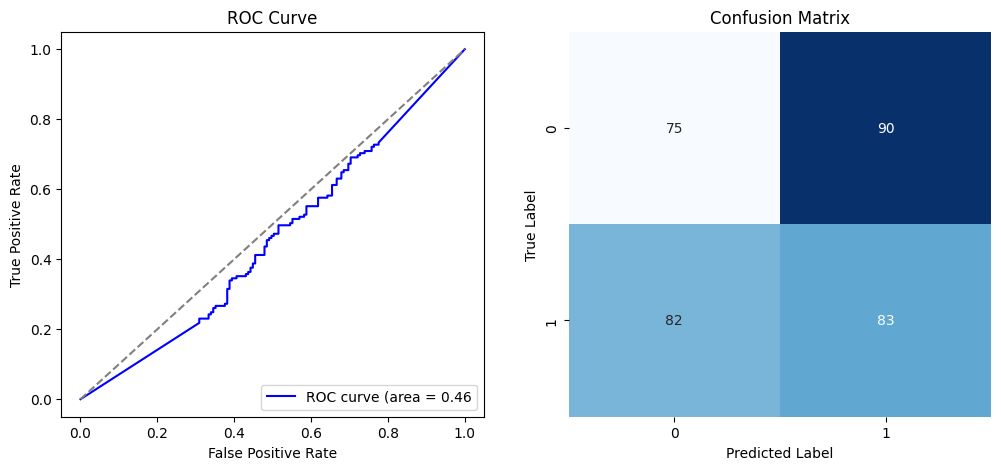

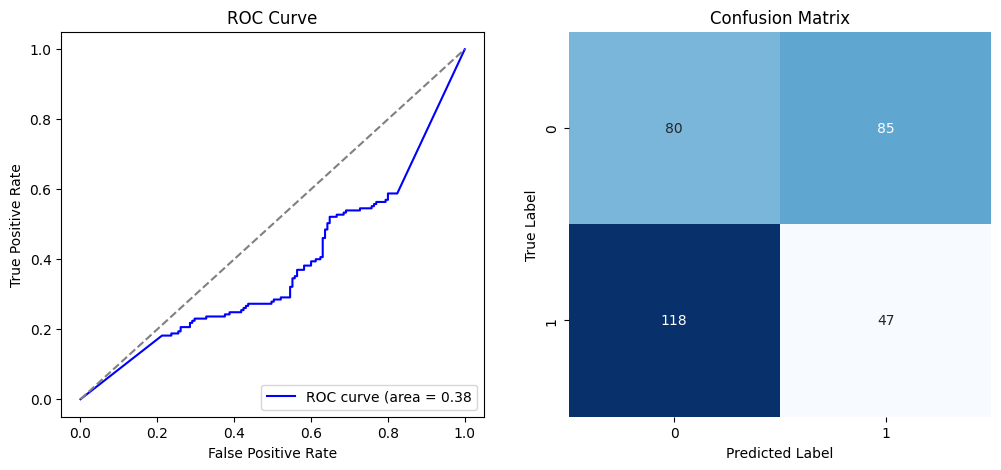

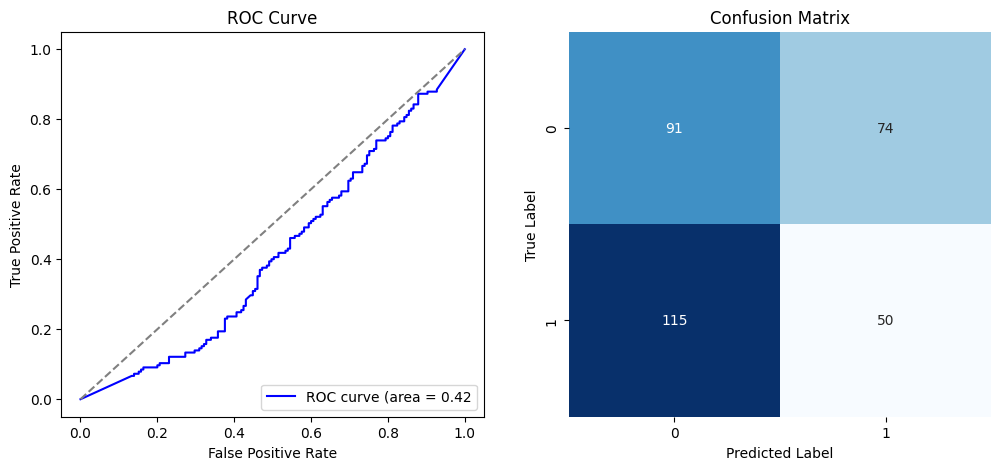

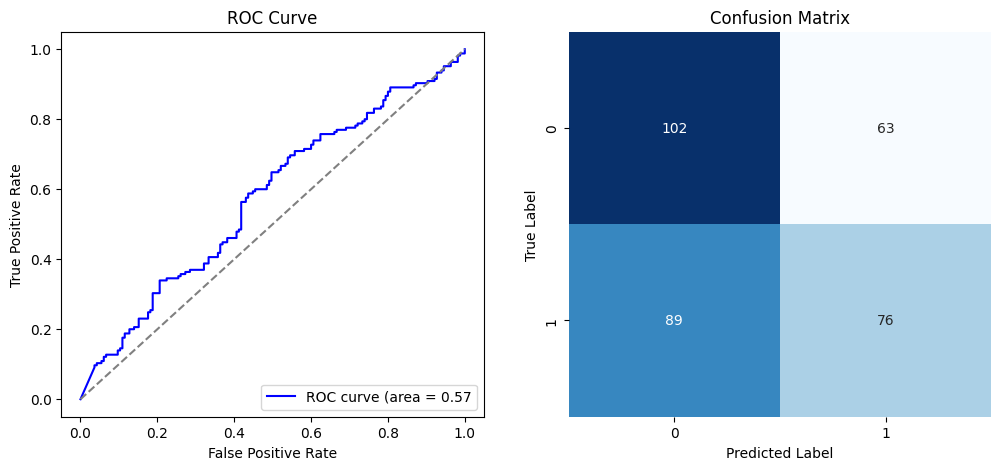

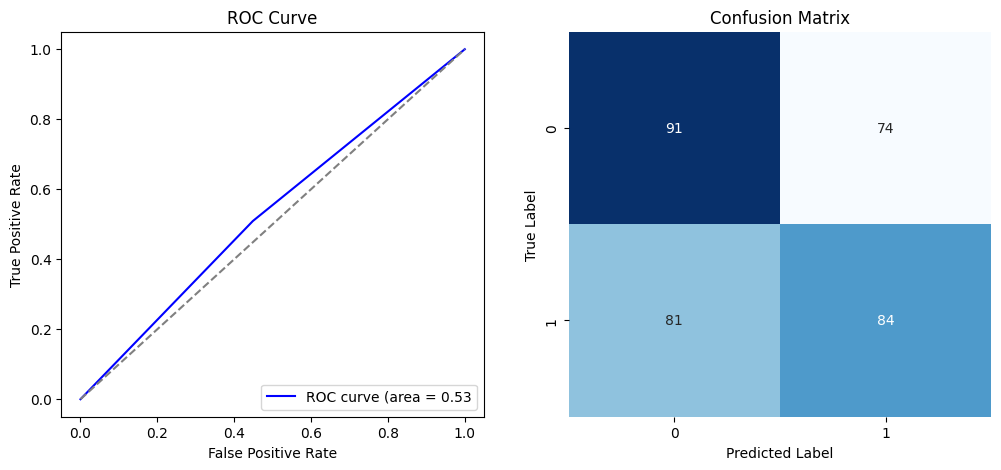

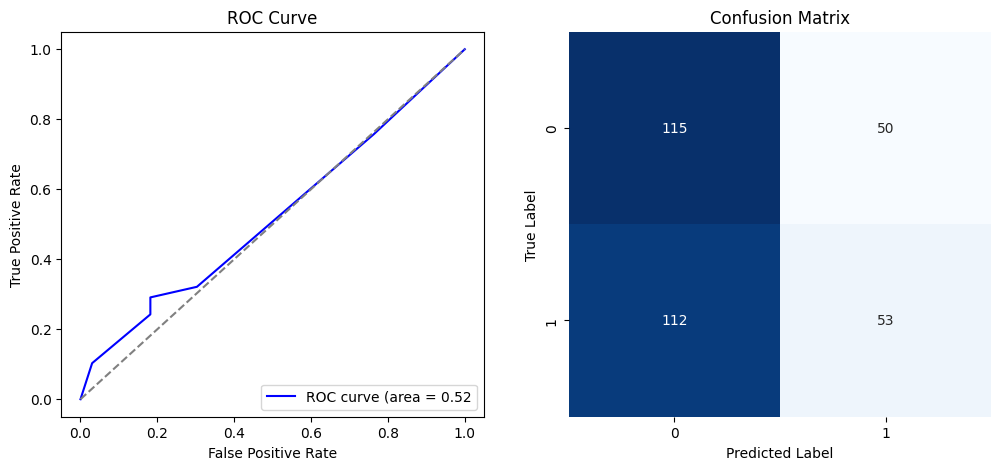

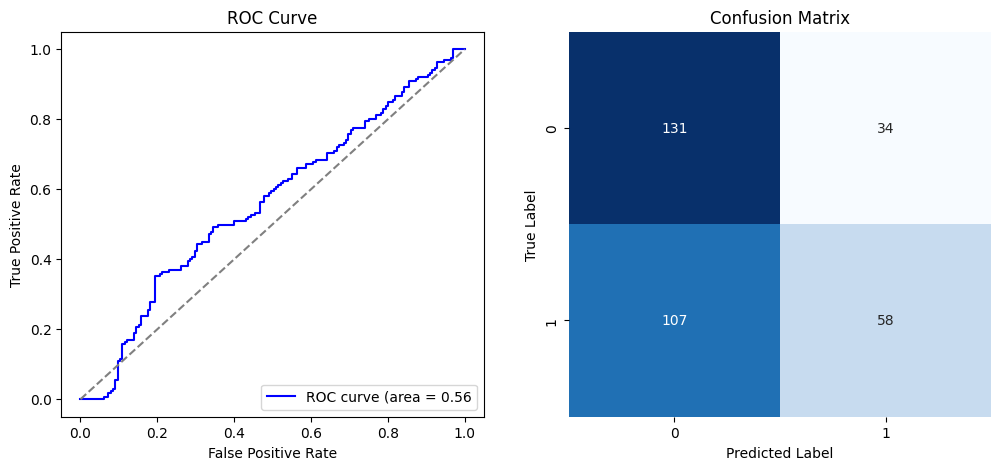

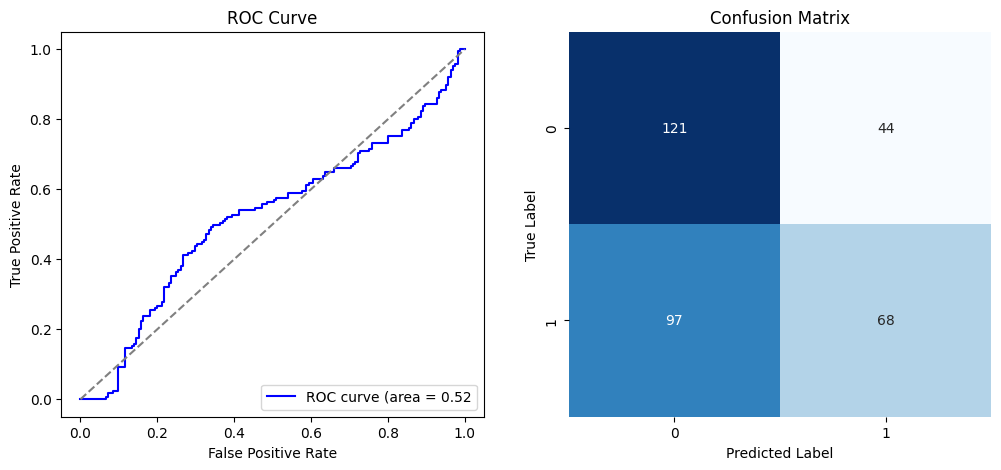

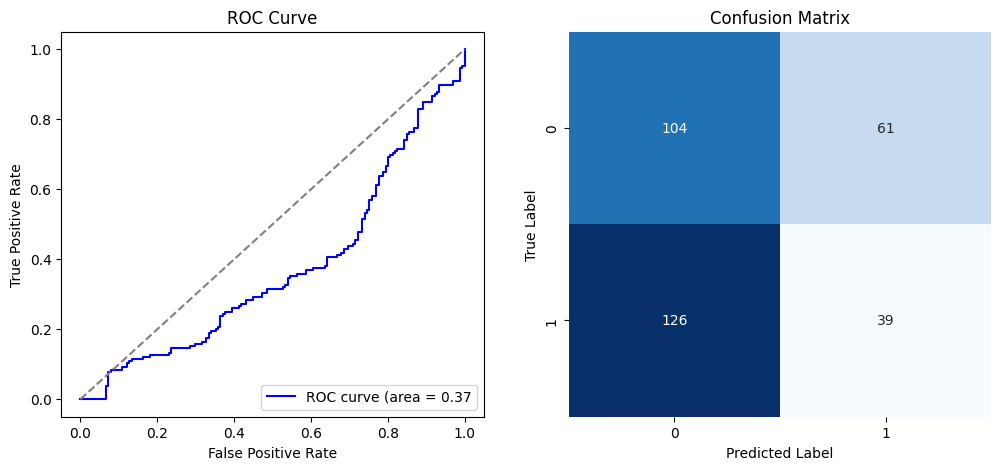

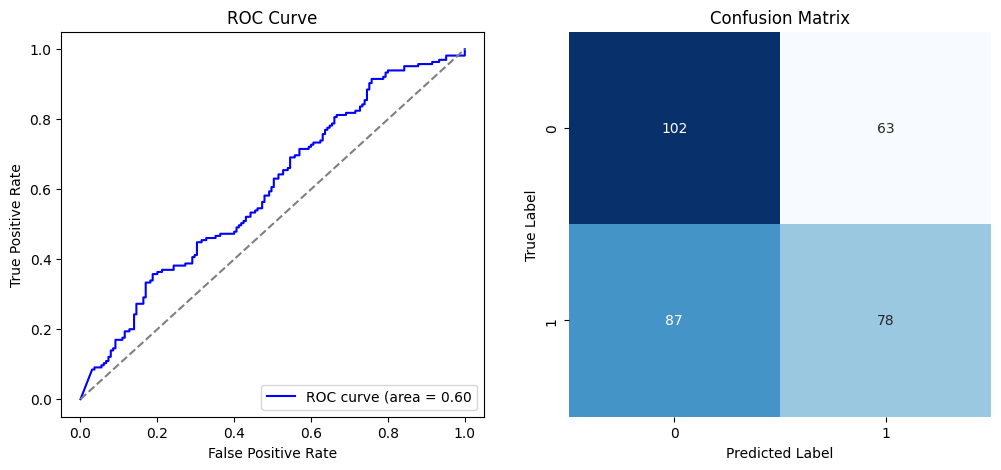

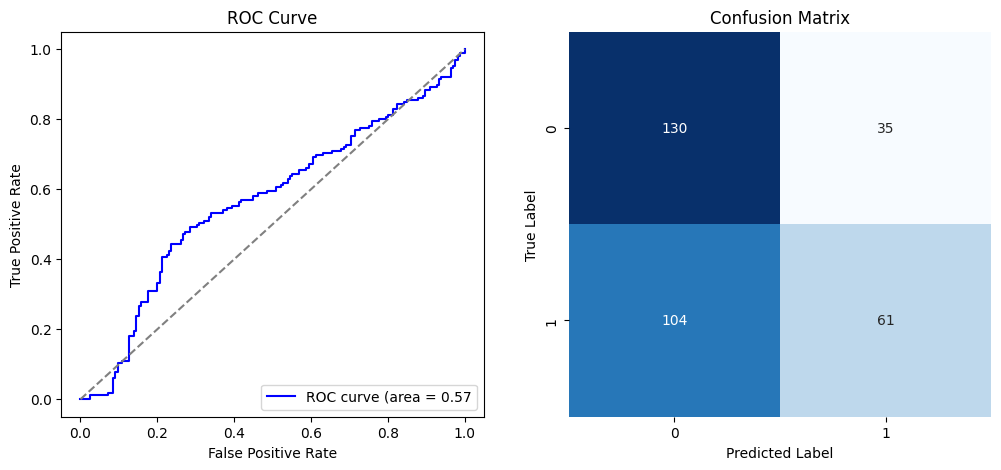

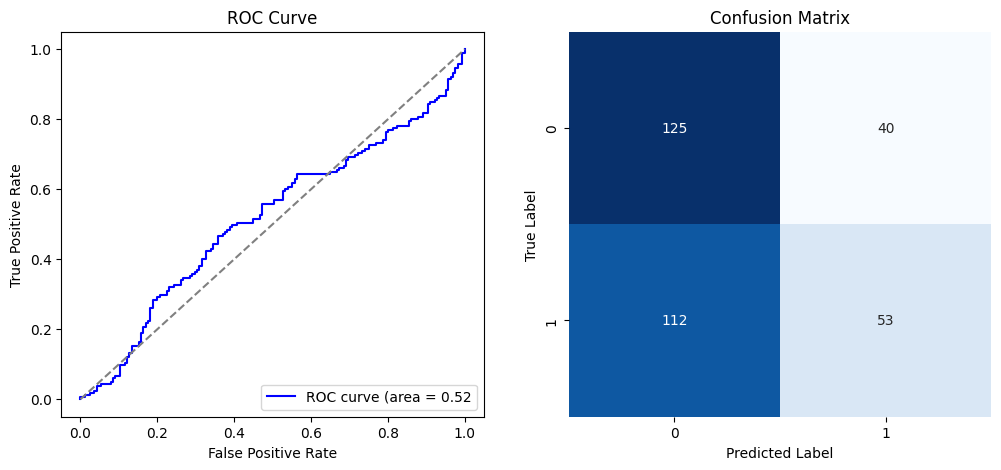

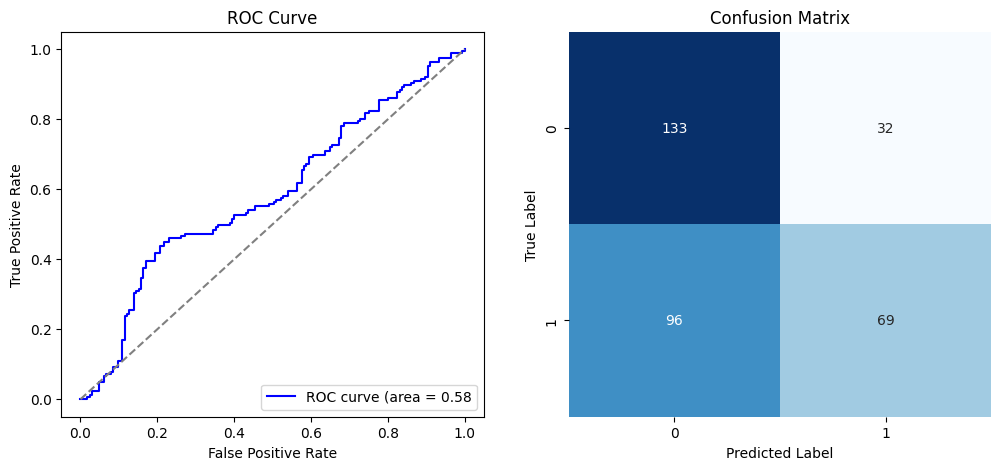

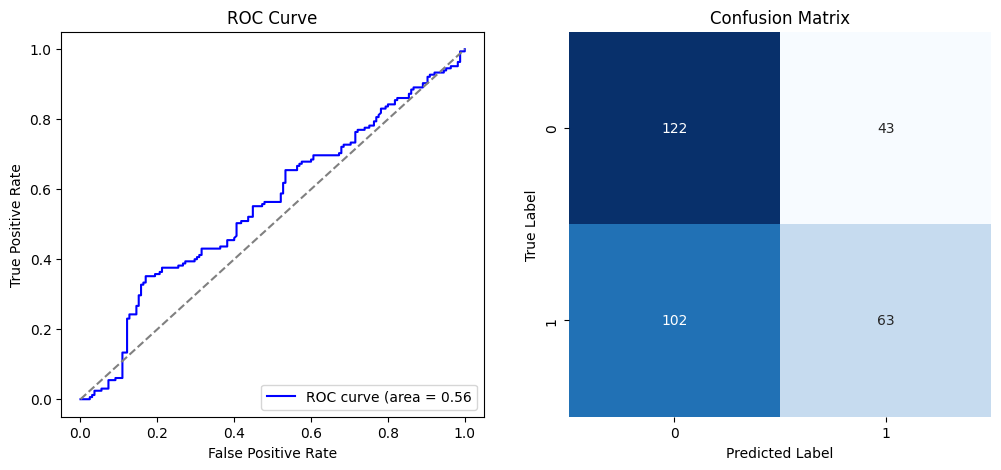

In [27]:
results = []

for modelName, (model, paramGrid) in models.items():
    for featureSelectorName, featureSelector in featureSelectors.items():
        print(f"Training {modelName} with {featureSelectorName}...")
        if featureSelector is not None:
            selector = featureSelector
        else:
            selector = None
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        bestFold = None
        bestAcc = -np.inf
        bestFoldModel = None
        bestFoldIdx = None
        hyperparamTuningDetails = []  

        if IS_HYPERPARAM_TUNING and paramGrid:
            gridSearch = GridSearchCV(model, paramGrid, cv=5, scoring="accuracy", n_jobs=-1, return_train_score=True)
            gridSearch.fit(X_train, y_train)
            model = gridSearch.best_estimator_
            bestParams = gridSearch.best_params_
            print(f"Best hyperparameters for {modelName}: {bestParams}")

            for i, params in enumerate(gridSearch.cv_results_["params"]):
                meanTestScore = gridSearch.cv_results_["mean_test_score"][i]
                stdTestScore = gridSearch.cv_results_["std_test_score"][i]
                hyperparamTuningDetails.append({
                    "params": params,
                    "mean_test_score": meanTestScore,
                    "std_test_score": stdTestScore
                })
        else:
            bestParams = None

        foldAccuracies = []
        foldPrecisions = []
        foldRecalls = []
        foldF1Scores = []
        selectedFeatures = []
        foldHcTrain = []
        foldMddTrain = []
        foldHcVal = []
        foldMddVal = []
        foldHcTest = []
        foldMddTest = []

        for fold, (trainIdx, valIdx) in enumerate(skf.split(X_train, y_train)):
            XTrain, XVal = X_train[trainIdx], X_train[valIdx]
            yTrain, yVal = y_train[trainIdx], y_train[valIdx]

            hcTrain = int(np.sum(yTrain == 0))
            mddTrain = int(np.sum(yTrain == 1))
            hcVal = int(np.sum(yVal == 0))
            mddVal = int(np.sum(yVal == 1))
            hcTest = int(np.sum(y_test == 0))
            mddTest = int(np.sum(y_test == 1))

            foldHcTrain.append(hcTrain)
            foldMddTrain.append(mddTrain)
            foldHcVal.append(hcVal)
            foldMddVal.append(mddVal)
            foldHcTest.append(hcTest)
            foldMddTest.append(mddTest)

            if selector is not None:
                XTrain = selector.fit_transform(XTrain, yTrain)
                XVal = XVal[:, selector.get_support()]

            model.fit(XTrain, yTrain)

            yPred = model.predict(XVal)
            acc = accuracy_score(yVal, yPred)
            prec = precision_score(yVal, yPred)
            rec = recall_score(yVal, yPred)
            f1 = f1_score(yVal, yPred)

            foldAccuracies.append(float(acc))
            foldPrecisions.append(float(prec))
            foldRecalls.append(float(rec))
            foldF1Scores.append(float(f1))

            if selector is not None:
                selectedFeatures.append(np.where(selector.get_support())[0].tolist())

            modelDir = os.path.join(whichDirForModelPath, f"{modelName}_{featureSelectorName}")
            if not os.path.exists(modelDir):
                os.makedirs(modelDir)
            modelFilename = os.path.join(modelDir, f"model_fold_{fold + 1}.pkl")
            joblib.dump(model, modelFilename)

            if acc > bestAcc:
                bestAcc = acc
                bestFold = model
                bestFoldIdx = fold

        print(f"Best fold: {bestFoldIdx + 1} with ACC score: {bestAcc:.4f}")

        if selector is not None:
            X_train_selected = selector.fit_transform(X_train, y_train)
            X_test_selected = X_test[:, selector.get_support()]
        else:
            X_train_selected = X_train
            X_test_selected = X_test

        bestFold.fit(X_train_selected, y_train)
        yTestPred = bestFold.predict(X_test_selected)
        finalAccuracy = accuracy_score(y_test, yTestPred)
        finalPrecision = precision_score(y_test, yTestPred)
        finalRecall = recall_score(y_test, yTestPred)
        finalF1 = f1_score(y_test, yTestPred)

        yProb = bestFold.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, yProb)
        roc_auc = auc(fpr, tpr)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f}')
        ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve')
        ax[0].legend(loc='lower right')

        cm = confusion_matrix(y_test, yTestPred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        ax[1].set_xlabel('Predicted Label')
        ax[1].set_ylabel('True Label')
        ax[1].set_title('Confusion Matrix')

        plotFilename = os.path.join(whichDirForModelPath, f"{modelName}_{featureSelectorName}_best_fold_roc_cm.png")
        plt.savefig(plotFilename)

        results.append({
            "model": modelName,
            "feature_selection": featureSelectorName,
            "avg_accuracy": f"{np.mean(foldAccuracies):.4f} ± {np.std(foldAccuracies):.4f}",
            "avg_precision": f"{np.mean(foldPrecisions):.4f} ± {np.std(foldPrecisions):.4f}",
            "avg_recall": f"{np.mean(foldRecalls):.4f} ± {np.std(foldRecalls):.4f}",
            "avg_f1_score": f"{np.mean(foldF1Scores):.4f} ± {np.std(foldF1Scores):.4f}",
            "final_accuracy": f"{finalAccuracy:.4f}",
            "final_precision": f"{finalPrecision:.4f}",
            "final_recall": f"{finalRecall:.4f}",
            "final_f1_score": f"{finalF1:.4f}",
            "significant_features": np.unique([item for sublist in selectedFeatures for item in sublist]).tolist(),
            "folds_accuracy": foldAccuracies,
            "folds_precision": foldPrecisions,
            "folds_recall": foldRecalls,
            "folds_f1_score": foldF1Scores,
            "fold_hc_train": [int(x) for x in foldHcTrain], 
            "fold_mdd_train": [int(x) for x in foldMddTrain],  
            "fold_hc_val": [int(x) for x in foldHcVal], 
            "fold_mdd_val": [int(x) for x in foldMddVal],  
            "fold_hc_test": [int(x) for x in foldHcTest],  
            "fold_mdd_test": [int(x) for x in foldMddTest],
            "best_fold": bestFoldIdx + 1,
            "best_hyperparameters": bestParams,
            "hyperparam_tuning_details": hyperparamTuningDetails
        })

resultsDf = pd.DataFrame(results)
resultsDf.to_csv(os.path.join(whichDirForModelPath, "results.csv"), index=False)
resultsDf.to_excel(os.path.join(whichDirForModelPath, "results.xlsx"), index=False)

for result in results:
    print(f"\n{result['model']} with {result['feature_selection']} - Final evaluation")
    print(f"Final Accuracy: {result['final_accuracy']}")
    print(f"Final Precision: {result['final_precision']}")
    print(f"Final Recall: {result['final_recall']}")
    print(f"Final F1 Score: {result['final_f1_score']}")
    if result["best_hyperparameters"]:
        print(f"Best Hyperparameters: {result['best_hyperparameters']}")
    if result["hyperparam_tuning_details"]:
        print(f"Hyperparameter Tuning Details: {result['hyperparam_tuning_details']}")